In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from werkzeug.wrappers import Request, Response

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# PRECIPITATION ANALYSIS

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

yearAgo = dt.date(2017, 8 ,23)-dt.timedelta(days=365)
# print(yearAgo)

# Perform a query to retrieve the last 12 months of precipitation data
sel = [Measurement.date, Measurement.prcp]
precipitation = session.query(*sel).filter(Measurement.date >= yearAgo).all()
# print(lastYear)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitationDF = pd.DataFrame(precipitation, columns=['Date', 'Precipitation']).set_index('Date')

# Sort the dataframe by date
precipDateDF = precipitationDF.groupby('Date').sum()
precipDateDF.head()


,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


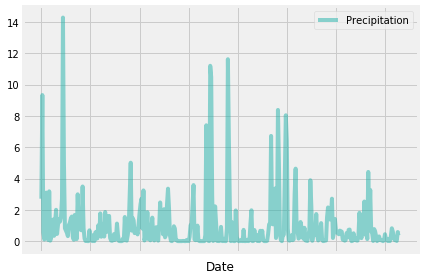

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precipDateDF.plot(color="lightseagreen", alpha=0.5)
plt.tight_layout()
plt.savefig('Images/precipitation.png')
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipDateDF.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# STATION ANALYSIS

In [14]:
# How many stations are available in this dataset? -- ANSWER: 9

# session.query(Station.station).count()
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [15]:
# What are the most active stations? 
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
# mCountStation = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
# mCountStation

# Create dataframe for most active stations
# countStations = pd.DataFrame(mCountStation, columns=['Station', 'Total Measurements Count']).sort_values('Total Measurements Count', ascending=False).reset_index(drop=True)
# countStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()

[(53.0, 87.0, 73.09795396419437)]

## TEMPERATURE OBSERVATIONS

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Design a query to retrieve the last 12 months of temperature observation data (tobs).
sel = [Measurement.station, Measurement.tobs]
session.query(*sel).filter(Measurement.date >= yearAgo).all()

# Filter by the station with the highest number of observations 
highObs = session.query(Measurement.station, Measurement.tobs).filter_by(station='USC00519281').filter(Measurement.date >= yearAgo).all()
highObsDF = pd.DataFrame(highObs)
highObsDF.head()


,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


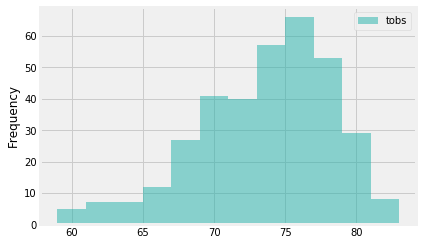

In [18]:
# Plot the results as a histogram with bins=12
highObsDF.plot.hist(bins=12, color="lightseagreen", alpha=0.5)
plt.savefig('Images/station-histogram.png')
plt.show()

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    

In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = "2017-07-04"
end_date = "2017-07-14"

temps = calc_temps(start_date, end_date)

tempsDF = pd.DataFrame(temps, columns=['tmin', 'tavg', 'tmax'])
tempsDF


,tmin,tavg,tmax
0,69.0,77.942857,82.0


In [21]:
tmin = tempsDF['tmin'].tolist()
tavg = tempsDF['tavg'].tolist()
tmax = tempsDF['tmax'].tolist()

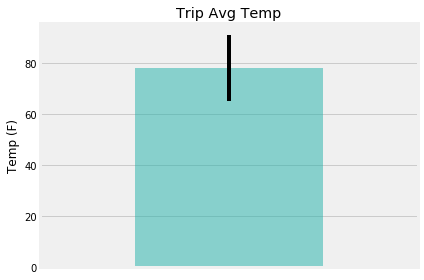

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = (tmax[0]-tmin[0])

tempsDF.plot.bar(y='tavg',yerr=error, color="lightseagreen", alpha=0.5, legend=None)

plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.tight_layout()
plt.savefig('Images/temperature.png')


In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()

rainfallDF = pd.DataFrame(rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total Rainfall'])
rainfallDF


,Station,Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,4.16
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.16
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,4.16
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.16
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.16
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,4.16
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.16
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,4.16
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,4.16


## CLIMATE APP

In [ ]:
# Design a Flask API based on the queries that you have just developed.
# Use FLASK to create your routes.

from flask import Flask, jsonify

app = Flask(__name__)

In [ ]:
### Routes: WELCOME
#  API welcome page listing all available APIs.
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Climate App: Available Routes:<br/>"
        f"<br/>"
        f"<a href='/api/v1.0/precipitation'>/api/v1.0/precipitation</a><br/>"
        f"List of prior year rain totals<br/>"
        f"<br/>"
        f"<a href='/api/v1.0/stations'>/api/v1.0/stations</a><br/>"
        f"List of all stations in dataset<br/>"
        f"<br/>"
        f"<a href='/api/v1.0/tobs'>/api/v1.0/tobs</a><br/>"
        f"List of prior year temperature observations<br/>"
        f"<br/>"
        f"<a href='/api/v1.0/<start>'>/api/v1.0/<start></a><br/>"
        f"List of the minimum, average and max temperatures for a given start date<br/>"
         f"<br/>"       
        f"<a href='/api/v1.0/<start>/<end>'>/api/v1.0/<start>/<end></a><br/>"
        f"List of the minimum, average and max temperatures for a given date start-end range<br/>"
    )

### Routes: PRECIPITATION
#   Query for the dates and precipitation from the last year.
#   Convert the query results to a Dictionary using `date` as the key and `prcp` as the value.
#   Return the JSON representation of your dictionary.

@app.route("/api/v1.0/precipitation")
def precipitation():
    yearAgo = dt.date.today()-dt.timedelta(days=365)
    results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yearAgo).all()
    all_results = []
    for r in results:
        results_dict = {}
        results_dict["date"]= r.date
        results_dict["prcp"] = r.prcp
        all_results.append(results_dict)
    return jsonify(all_results)

### Routes:STATIONS
#   Return a JSON list of stations from the dataset.

@app.route("/api/v1.0/stations")
def stations():
    stations = session.query(Station.station, Station.name).all()
    return jsonify(stations)

### Routes: TEMPERATURE OBSERVATIONS
#   Return a JSON list of Temperature Observations (tobs) for the previous year

@app.route("/api/v1.0/tobs")
def temperature():
    yearAgo = dt.date.today()-dt.timedelta(days=365)
    results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= yearAgo).all()
    all_results = []
    for r in results:
        results_dict = {}
        results_dict["date"]= r.date
        results_dict["tobs"] = r.tobs
        all_results.append(results_dict)
    return jsonify(all_results)

### Routes: START 
#   Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
#   When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

@app.route("/api/v1.0/<start>")
def start(start):
    start = "2017-07-04"
    end = "2017-07-14"
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start).all()
    print(results)
    all_results = list(np.ravel(results))
    return(jsonify(all_results))

### Routes: START & END
#   When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

@app.route("/api/v1.0/<start>/<end>")
def start_end(start, end):
    start = "2017-07-04"
    end = "2017-07-14"
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    all_results = list(np.ravel(results))
    return(jsonify(all_results))

# Runs the application
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Aug/2018 23:32:26] "GET / HTTP/1.1" 200 -
